# 폐렴 진단 데이터 준비

- 모델 VGG16(keras) 사용

In [23]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import glob 
import cv2

In [3]:
np.random.seed(42)
tf.random.set_seed(42) 

In [4]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 적재

In [53]:
train_normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')
train_pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

test_normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')
test_pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

# 데이터 시각화

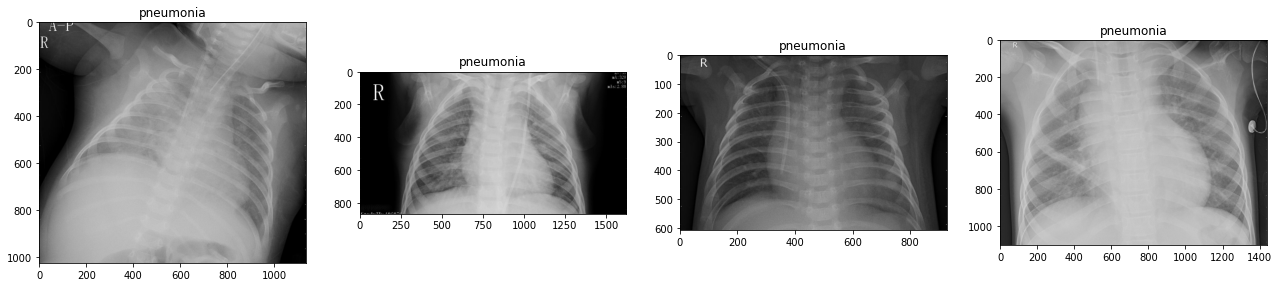

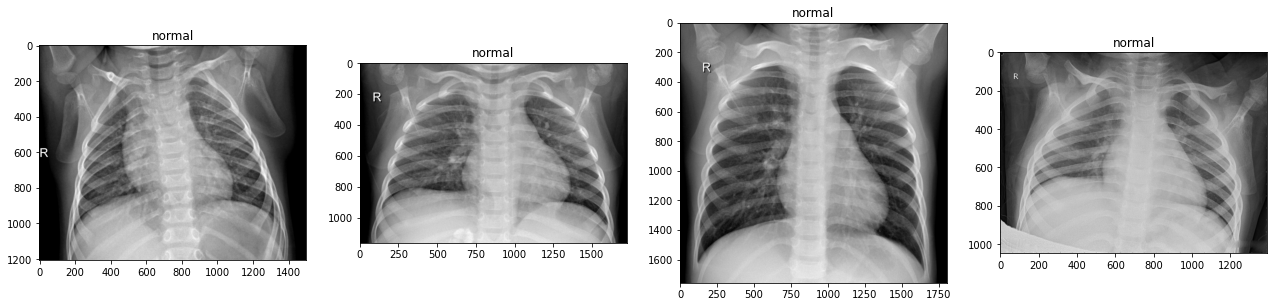

In [29]:
pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(pneumonia))
    image = cv2.cvtColor(cv2.imread(pneumonia[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title('pneumonia')

normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(normal))
    image = cv2.cvtColor(cv2.imread(normal[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title('normal')

# 데이터 분리 

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split


# train_df
train_path = train_normal + train_pneumonia # 4000 4005 (Cat/Dog)
train_label = ["NORMAL" for _ in range(len(train_normal))] + ["PNEUMONIA" for _ in range(len(train_pneumonia))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})


# test_df
test_paths = test_normal + test_pneumonia # 1011 1012 (Cat/Dog)
test_label = ["NORMAL" for _ in range(len(test_pneumonia))] + ["PNEUMONIA" for _ in range(len(test_normal))]
test_df = pd.DataFrame({"path":test_paths, "label":test_label})

# valid_df
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

PNEUMONIA    3099
NORMAL       1073
Name: label, dtype: int64
PNEUMONIA    776
NORMAL       268
Name: label, dtype: int64


# 데이터 분리 후 전처리

In [61]:
BATCH_SIZE = 64
# train_generator
train_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 20, 
                                    rescale = 1/255.0
                                    ) # 다양한 Augmentation 시도해보기!!!
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=True)

# valid_generator
valid_generator = ImageDataGenerator(rescale = 1/255.0)

valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)


# test_generator
test_generator = ImageDataGenerator(rescale = 1/255.0)

test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 5216 validated image filenames belonging to 2 classes.


In [62]:
train_batch, label_batch = next(train_generator_iterator)
train_batch.shape, label_batch.shape

((64, 224, 224, 3), (64,))

# 모델 생성

## VGG16(keras) 모델 사용

- VGG16 의 특징

- VGG(Visual Geometry Group)16(16layers)
- VGGnet은 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델로 사용하기 쉬운 구조와 높은 성능을 가지고 있음
- 2014년 이미지넷 이미지 인식 대회에서 준우승을 한 모델
- VGGnet은 16개 또는 19개 층으로 구성된 모델을 의미함

In [63]:
IMAGE_SIZE = 224

def build_vgg16():
  tf.keras.backend.clear_session()
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
  x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block1_conv1")(input_tensor)
  x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block1_conv2")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool")(x) 

  x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block2_conv1")(x)
  x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block2_conv2")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool")(x) 
    
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv1")(x)
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv2")(x)  
  x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block3_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool")(x) 

  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv1")(x)
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv2")(x)  
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block4_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool")(x) 
    
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv1")(x)
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv2")(x)  
  x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding="same", activation="relu", name="block5_conv3")(x)  
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool")(x)   # 7*7*512
    

  x = GlobalAveragePooling2D()(x) # 512
  x = Dense(50, activation="relu")(x)
  output = Dense(units=1, activation='sigmoid')(x)


  model = Model(inputs=input_tensor, outputs=output)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
  return model

model = build_vgg16()
model.summary()

2023-01-12 03:15:12.385671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 03:15:12.478030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 03:15:12.478782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 03:15:12.479985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [64]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [65]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

2023-01-12 03:16:23.879926: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-12 03:16:23.879973: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-12 03:16:23.882346: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-12 03:16:24.110145: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-12 03:16:24.110330: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [66]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

2023-01-12 03:17:50.666105: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2023-01-12 03:17:54.754673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/66 [..............................] - ETA: 18:12 - loss: 0.6929 - accuracy: 0.7812

2023-01-12 03:18:07.538204: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-12 03:18:07.538260: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/66 [..............................] - ETA: 44s - loss: 0.6917 - accuracy: 0.7734  

2023-01-12 03:18:08.208346: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-12 03:18:08.209345: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-12 03:18:08.351485: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 367 callback api events and 364 activity events. 
2023-01-12 03:18:08.365917: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-12 03:18:08.388299: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2023_01_12-03_16_23/train/plugins/profile/2023_01_12_03_18_08

2023-01-12 03:18:08.397897: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_12-03_16_23/train/plugins/profile/2023_01_12_03_18_08/a469a04df304.trace.json.gz
2023-01-12 03:18:08.433718: I tensorflow/core/profiler/rpc/clien

66/66 [==============================] - 155s 2s/step - loss: 0.6154 - accuracy: 0.7428 - val_loss: 0.5718 - val_accuracy: 0.7433

Epoch 00001: val_loss improved from inf to 0.57182, saving model to my_best_model.h5
Epoch 2/40
66/66 [==============================] - 108s 2s/step - loss: 0.5386 - accuracy: 0.7500 - val_loss: 0.6197 - val_accuracy: 0.5498

Epoch 00002: val_loss did not improve from 0.57182
Epoch 3/40
66/66 [==============================] - 107s 2s/step - loss: 0.3604 - accuracy: 0.8408 - val_loss: 0.3028 - val_accuracy: 0.8602

Epoch 00003: val_loss improved from 0.57182 to 0.30276, saving model to my_best_model.h5
Epoch 4/40
66/66 [==============================] - 108s 2s/step - loss: 0.2859 - accuracy: 0.8837 - val_loss: 0.3184 - val_accuracy: 0.8534

Epoch 00004: val_loss did not improve from 0.30276
Epoch 5/40
66/66 [==============================] - 107s 2s/step - loss: 0.2417 - accuracy: 0.9058 - val_loss: 0.4184 - val_accuracy: 0.8151

Epoch 00005: val_loss did

# 모델 성능 검증

- 로스율 1% 미만 적중율 98% 이상의 높은 성능을 보여줌

In [67]:
model.evaluate(train_generator_iterator)

82/82 [==============================] - 66s 794ms/step - loss: 5.7248 - accuracy: 0.5157


[5.724786281585693, 0.5157208442687988]

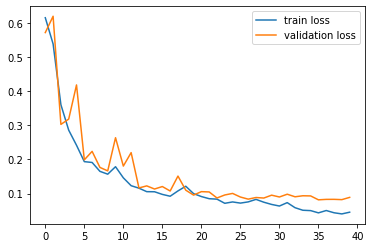

In [68]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

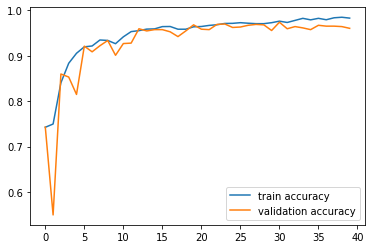

In [69]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()